## Initial setup
##### This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
##### This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
##### For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [2]:

'''
Based on Enayat A. Moallemi version from May 2018

edited by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on 18 December 2019

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
import glob

## SOBOL visualization functions
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 25

In [3]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, levers, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=levers)

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=levers,
                      columns=levers)
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = levers
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [4]:
from ema_workbench import load_results

results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')


In [5]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [6]:
experiments


,annualCpi,annualInflation,capacityFactorChangeBrownCoal,capacityFactorChangeWater,consumption,distributionUsageChange,energyEfficiency,generationRolloutPeriod,generatorRetirement,includePublicallyAnnouncedGen,...,priceChangePercentageWind,retailUsageChange,rooftopPV,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,technologicalImprovement,scenario,policy,model
0,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,0,Gr4sp
1,0.048008,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,1,Gr4sp
2,0.018789,0.031602,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,2,Gr4sp
3,0.018789,0.013867,1.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,3,Gr4sp
4,0.018789,0.013867,0.0,8.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,4,Gr4sp
5,0.018789,0.013867,0.0,3.0,Central,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,5,Gr4sp
6,0.018789,0.013867,0.0,3.0,Slow change,9.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,6,Gr4sp
7,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,7,Gr4sp
8,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,3.0,0.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,8,Gr4sp
9,0.018789,0.013867,0.0,3.0,Slow change,8.0,Central,8.0,-4.0,False,...,-8.0,4.0,residential,secondary,21.795020,Fast change,0.054980,None,9,Gr4sp


##### The outcomes are shown in year. Though another analysis cadone for monthly outcomes. 
##### In total, there are 33 levers. These are listed below.

In [8]:
#outcomes Options: wholesalePriceYear, GHGYear, tariffsYear, primarySpotProductionYear,
# secondarySpotProductionYear, offSpotProductionYear, rooftopPvProductionYear
# numActorsYear
outcomes_to_show = ['GHGYear','wholesalePriceYear', 'tariffsYear','primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'rooftopPVProductionYear' ]

# 22 levers selected after EET
levers = ['consumption', 'energyEfficiency', 'rooftopPV', 'solarUptake','annualCpi','annualInflation',
          'includePublicallyAnnouncedGen','generationRolloutPeriod','generatorRetirement','technologicalImprovement',
          'priceChangePercentageBrownCoal','priceChangePercentageWind','priceChangePercentageWater','capacityFactorChangeBrownCoal','capacityFactorChangeWater',
          'distributionUsageChange','retailUsageChange',
          'semiScheduleGenSpotMarket','semiScheduleMinCapMarketGen', 'nonScheduleGenSpotMarket', 'nonScheduleMinCapMarketGen', 
          'learningCurve' ]

#from startYear
startYear = 1998
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

In [26]:
for l in levers:
    var = experiments[l]
    val = np.unique(var)
    print("{}: {}".format(l,val))

consumption: ['Central' 'Fast change' 'Slow change' 'Step change']
energyEfficiency: ['Central' 'Slow change']
rooftopPV: ['business' 'residential']
solarUptake: ['Central' 'Fast change' 'Slow change' 'Step change']
annualCpi: [0.01001953 0.0100293  0.01003906 ... 0.04990234 0.04994141 0.04998047]
annualInflation: [0.01001953 0.01005859 0.01009766 ... 0.04990234 0.04994141 0.04998047]
includePublicallyAnnouncedGen: [False]
generationRolloutPeriod: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
generatorRetirement: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.]
technologicalImprovement: [4.88281250e-05 1.46484375e-04 2.44140625e-04 ... 9.97558594e-02
 9.98535156e-02 9.99511719e-02]
priceChangePercentageBrownCoal: [-30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.
 -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.
  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.
  26.  27.  28

## SOBOL
##### To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

In [9]:
from gr4spModelSOBOL import getModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModel()
leversCategories = determine_parameters(model, 'levers', union=False) 
problem = get_SALib_problem(leversCategories)

# Build input values as floats used for each lever to generate outcomes. Recover them from experiments variable
X = None
for l in levers:
    col_cat = None
    # map category to an index
    if isinstance(model.levers[l], CategoricalParameter):
        col_cat = [ float(model.levers[l].index_for_cat(cat)) for cat in experiments[l] ]
    else:
        col_cat = [ float(cat) for cat in experiments[l] ]
    
    # Concatenate each lever
    if X is None:
        X=col_cat
    else:
        X = np.column_stack((X,col_cat))




In [15]:
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s1_conf_years_ooi = {}
st_years_ooi = {}
st_conf_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_levers = len(levers)
for ooi in outcomes_to_show:
    sobol_stats_years = pd.DataFrame([],columns=levers)
    s1_years = pd.DataFrame([],columns=levers)
    s1_conf_years = pd.DataFrame([],columns=levers)
    st_years = pd.DataFrame([],columns=levers)
    st_conf_years = pd.DataFrame([],columns=levers)
    s2_years = {}
    s2_conf_years = {}
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_levels = p to do the analysis with p levels
        stdY = dataY.std()
        
        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_levers )
            sobol_indices['ST_conf'] = np.zeros( num_levers )
            sobol_indices['S1'] = np.zeros( num_levers )
            sobol_indices['S1_conf'] = np.zeros( num_levers )
            sobol_indices['S2'] = np.zeros( (num_levers, num_levers) )
            sobol_indices['S2_conf'] = np.zeros( (num_levers, num_levers) )
        else:
            sobol_indices = sobol.analyze(problem, dataY)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=levers)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=levers)
        s1_conf = pd.DataFrame([sobol_indices['S1_conf']], columns=levers)
        st = pd.DataFrame([sobol_indices['ST']], columns=levers)
        st_conf = pd.DataFrame([sobol_indices['ST_conf']], columns=levers)
        s2 = pd.DataFrame(sobol_indices['S2'], index=levers, columns=levers)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=levers)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s1_conf_years = s1_conf_years.append(s1_conf, sort=False)
        st_years = st_years.append(st, sort=False)
        st_conf_years = st_conf_years.append(st_conf, sort=False)
        s2_years[startYear+t] = s2
        s2_conf_years[startYear+t] = s2_conf
        print("{} - std: {}".format(startYear+t, stdY ) )
    
    s1_years = s1_years.set_index(time)        
    s1_conf_years = s1_conf_years.set_index(time)
    st_years = st_years.set_index(time)
    st_conf_years = st_conf_years.set_index(time)

    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    s1_years_ooi[ooi] = s1_years
    s1_conf_years_ooi[ooi] = s1_conf_years
    st_years_ooi[ooi] = st_years
    st_conf_years_ooi[ooi] = st_conf_years
    s2_years_ooi[ooi] = s2_years
    s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    #break
    


1998 - std: 0.0
1999 - std: 0.0
2000 - std: 0.4309249129245422
2001 - std: 0.4810536952260896
2002 - std: 0.49742668652924793
2003 - std: 0.4588246264175272
2004 - std: 0.33438005159338036
2005 - std: 0.2836739122104976
2006 - std: 0.27077966946449167
2007 - std: 0.27077966946449167
2008 - std: 0.27077966946449167
2009 - std: 0.27077966946449167
2010 - std: 0.27077966946449167
2011 - std: 0.27077966946449167
2012 - std: 0.27077966946449167
2013 - std: 0.27077966946449167
2014 - std: 0.27081180548101347
2015 - std: 0.27094029560989324
2016 - std: 0.2738720198572258
2017 - std: 0.4773068429103987
2018 - std: 0.4684714641609813
2019 - std: 0.4983200803643489
2020 - std: 0.47637959832527643
2021 - std: 0.4273223608960071
2022 - std: 0.38266256017998446
2023 - std: 0.3744645645135773
2024 - std: 0.31057903593103425
2025 - std: 0.2585358983855884
2026 - std: 0.20531591186318338
2027 - std: 0.1608028178220021
2028 - std: 0.12596920358310615
2029 - std: 0.08892399800228246
2030 - std: 0.057816

#### Average and Max S1,ST,S2 and confidence intervals for all years in data frame

In [16]:
s1_average_ooi = {}
s1_max_val_ooi = {}
s1_conf_average_ooi = {}
s1_conf_max_val_ooi = {}
s2_average_ooi = {}
s2_max_val_ooi = {}
s2_conf_average_ooi = {}
s2_conf_max_val_ooi = {}
st_average_ooi = {}
st_max_val_ooi = {}
st_conf_average_ooi = {}
st_conf_max_val_ooi = {}

ntime = len(time)
for ooi in outcomes_to_show:
    
    s1_average_ooi[ooi] = s1_years_ooi[ooi].mean()    
    s1_max_val_ooi[ooi] = s1_years_ooi[ooi].max()
    s1_conf_average_ooi[ooi] = s1_conf_years_ooi[ooi].mean()    
    s1_conf_max_val_ooi[ooi] = s1_conf_years_ooi[ooi].max()
    st_average_ooi[ooi] = st_years_ooi[ooi].mean()
    st_max_val_ooi[ooi] = st_years_ooi[ooi].max()
    st_conf_average_ooi[ooi] = st_conf_years_ooi[ooi].mean()
    st_conf_max_val_ooi[ooi] = st_conf_years_ooi[ooi].max()
    
    s2_max_val = pd.DataFrame(np.zeros((num_levers, num_levers)), index=levers, columns=levers)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_levers):
                if s2_max_val[i][j] < s2_val[i][j]:
                    s2_max_val[i][j] = s2_val[i][j]
    s2_max_val_ooi[ooi] = s2_max_val

    s2_conf_max_val = pd.DataFrame(np.zeros((num_levers, num_levers)), index=levers, columns=levers)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_levers):
                if s2_conf_max_val[i][j] < s2_conf_val[i][j]:
                    s2_conf_max_val[i][j] = s2_conf_val[i][j]
    s2_conf_max_val_ooi[ooi] = s2_conf_max_val    

    s2_avg_val = pd.DataFrame(np.zeros((num_levers, num_levers)), index=levers, columns=levers)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_levers):                
                    s2_avg_val[i][j] += s2_val[i][j]
                    if time[-1] == year:
                        s2_avg_val[i][j] /= ntime
    s2_average_ooi[ooi] = s2_avg_val
    
    s2_conf_avg_val = pd.DataFrame(np.zeros((num_levers, num_levers)), index=levers, columns=levers)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_levers):                
                    s2_conf_avg_val[i][j] += s2_conf_val[i][j]
                    if time[-1] == year:
                        s2_conf_avg_val[i][j] /= ntime
    s2_conf_average_ooi[ooi] = s2_conf_avg_val
    

## Bar plots of s1,st,s2,s2_conf 
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 21 

GHGYear


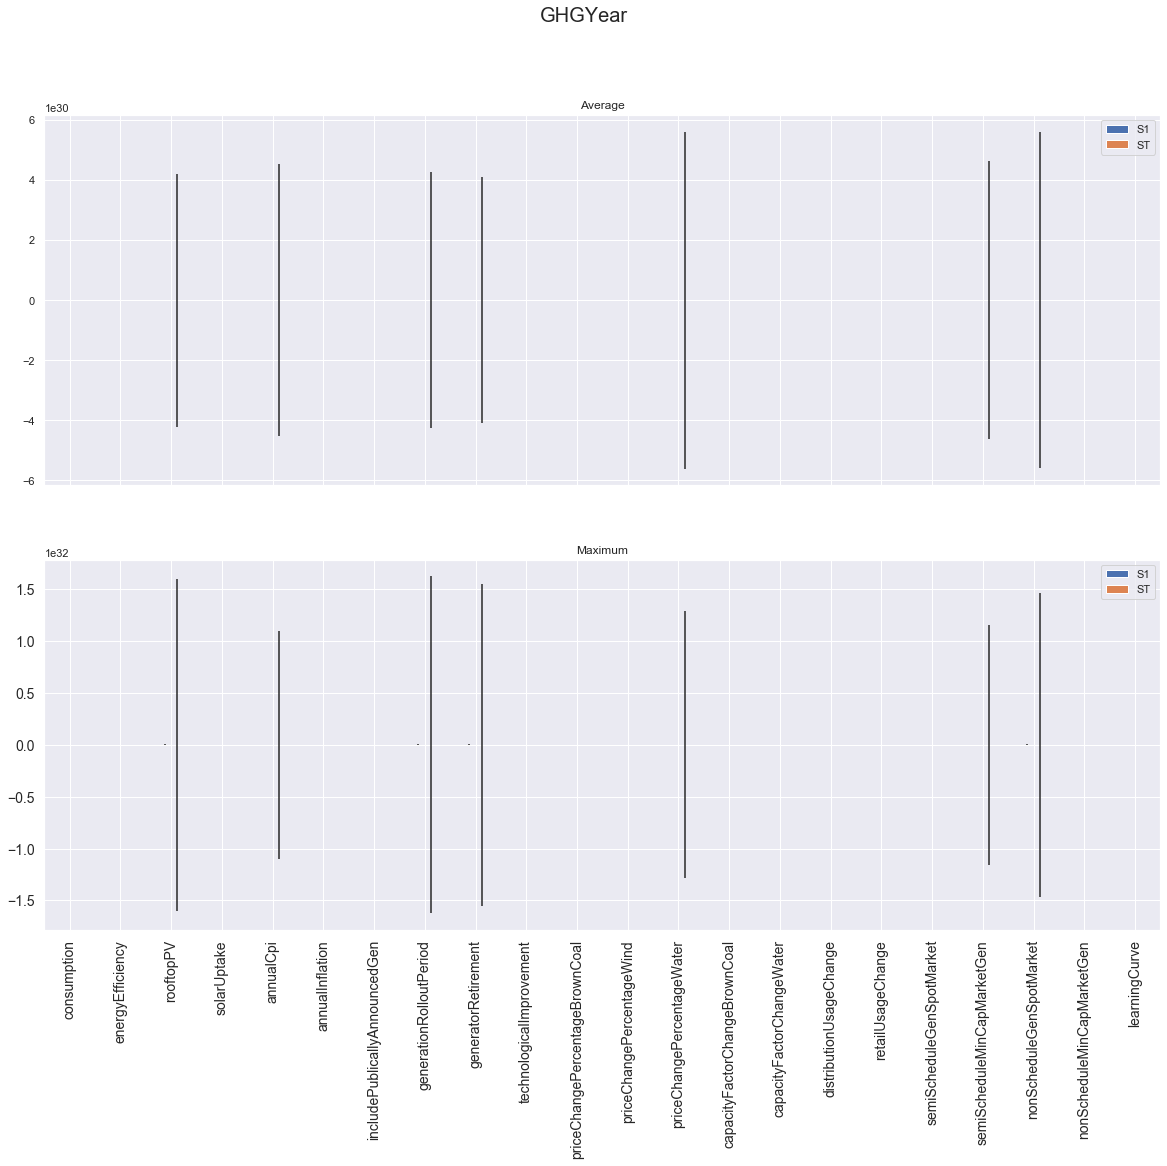

In [17]:
import seaborn as sns; sns.set()

writer = pd.ExcelWriter('{}/SOBOL_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp', '_avg_sensitivity_Indices'), engine='xlsxwriter')

#f = plt.figure(figsize=(20,30)) 
for ooi in outcomes_to_show:
    
    fig, ax = plt.subplots(2, sharex=True)
    fig.set_size_inches(20,15)
    fig.suptitle(ooi, fontsize=20)
    
    ax[0].set_title("Average")
    ax[1].set_title("Maximum")
    
    plt.xticks (fontsize = 14)
    plt.yticks (fontsize = 14)
    
    Si_df_avg = pd.concat({'S1': s1_average_ooi[ooi],'ST': st_average_ooi[ooi],'S1_conf': s1_conf_average_ooi[ooi],'ST_conf': st_conf_average_ooi[ooi]}, axis=1)
    Si_df_max = pd.concat({'S1': s1_max_val_ooi[ooi],'ST': st_max_val_ooi[ooi],'S1_conf': s1_conf_max_val_ooi[ooi],'ST_conf': st_conf_max_val_ooi[ooi]}, axis=1)
    
    indices_avg = Si_df_avg[['S1','ST']]
    err_avg = Si_df_avg[['S1_conf','ST_conf']]
    
    indices_max = Si_df_max[['S1','ST']]
    err_max = Si_df_max[['S1_conf','ST_conf']]


    Si_df_avg.to_excel(writer, sheet_name=ooi)

    
    indices_avg.plot.bar(yerr=err_avg.values.T,ax=ax[0])
    indices_max.plot.bar(yerr=err_max.values.T,ax=ax[1])

    #sns.scatterplot(x='mu_star_max',y='sigma_max', hue=df_max.index, data=df_max)
    
    #df_max.plot.scatter(x='mu_star_max',y='sigma_max',c='DarkBlue')
        

    print(ooi)

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_barplot_s1_st_%s'%(ooi)),dpi=300, bbox_inches='tight')
    #break

writer.save()

## Create S2, S1, and ST plots

GHGYear


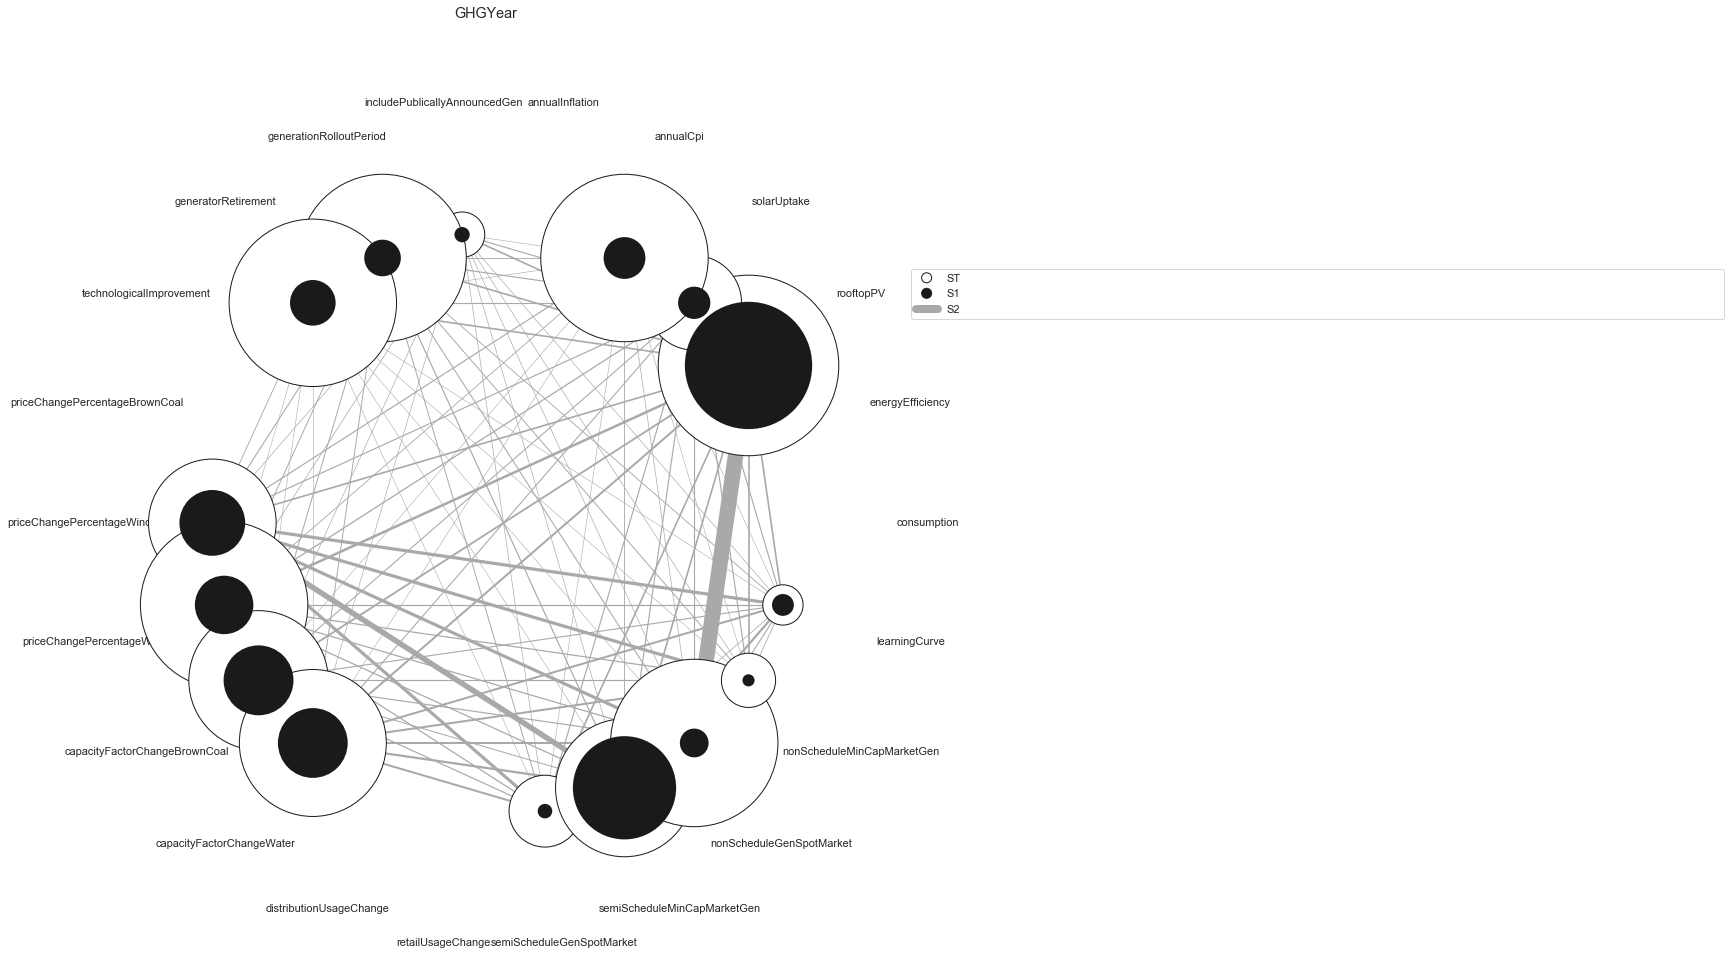

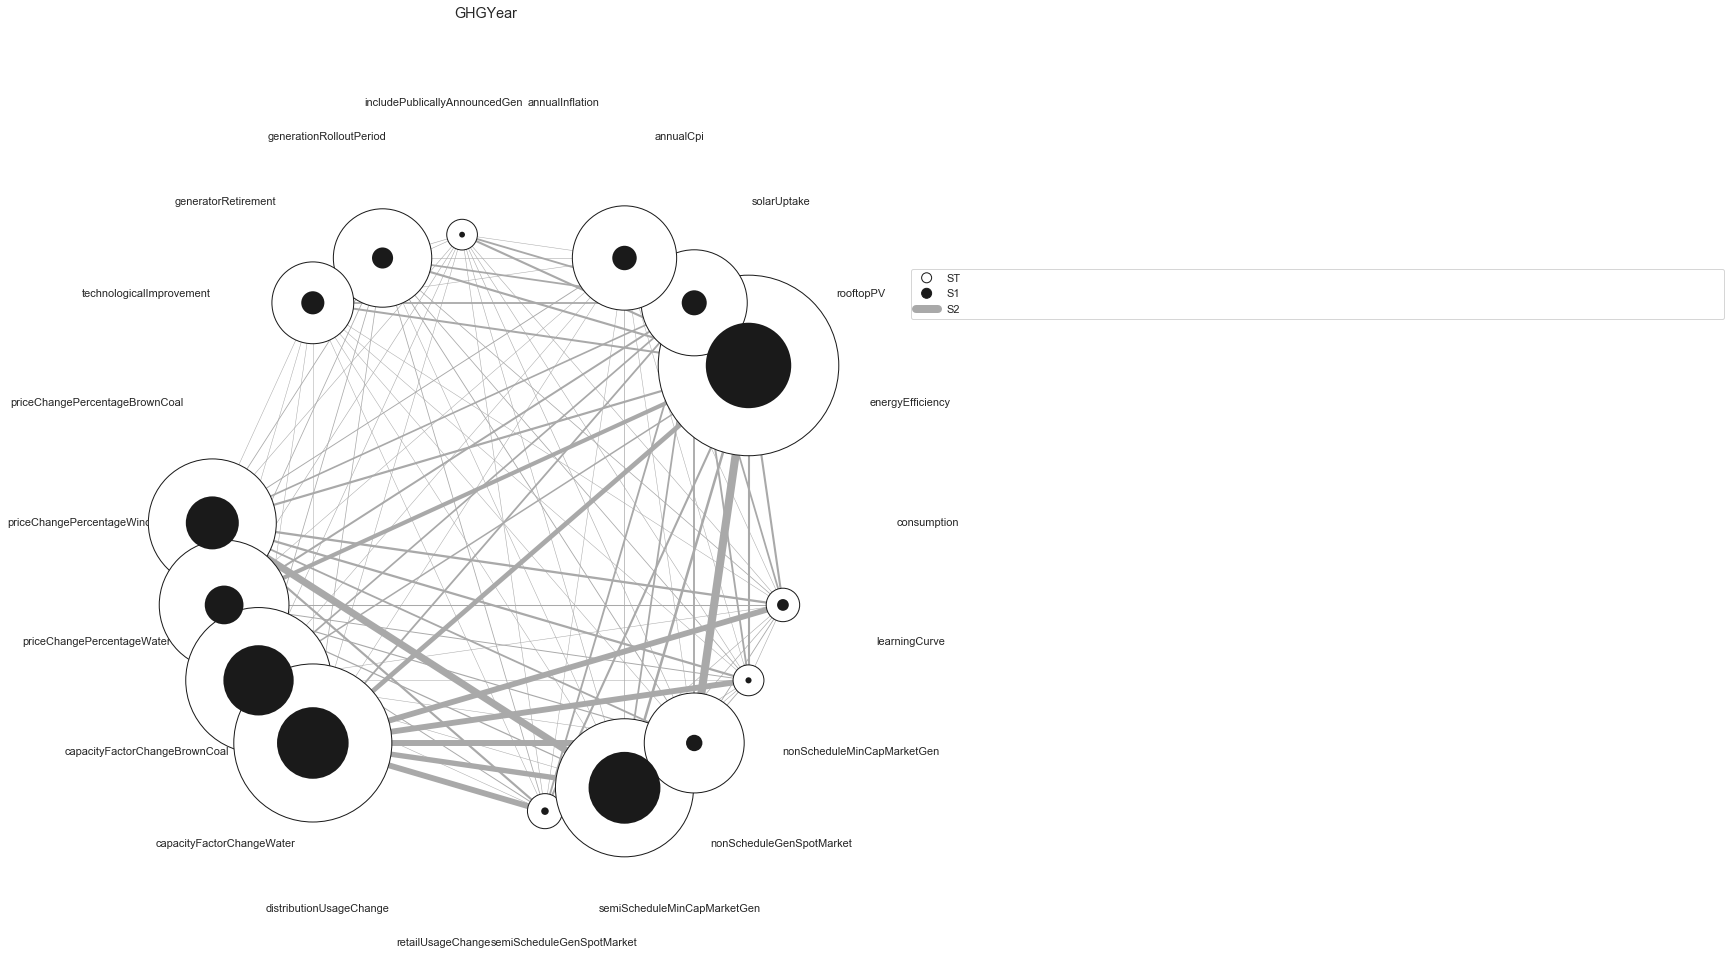

In [18]:
#%matplotlib inline
sns.set_style('whitegrid')

for ooi in outcomes_to_show:
    
    #Maximum
    Si_df_max = {'S1': s1_max_val_ooi[ooi].to_numpy(),'S2': s2_max_val_ooi[ooi].to_numpy(),'ST': st_max_val_ooi[ooi].to_numpy(),'S1_conf': s1_conf_max_val_ooi[ooi].to_numpy(),'S2_conf': s2_conf_max_val_ooi[ooi].to_numpy(),'ST_conf': st_conf_max_val_ooi[ooi].to_numpy()}
    
    fig = plot_sobol_indices(Si_df_max, levers, criterion='ST', threshold=0.005)
    fig.set_size_inches(20,15)
    fig.suptitle(ooi)   

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_sobol_max_%s'%(ooi)),dpi=300, bbox_inches='tight')
    
    #Average
    Si_df_avg = {'S1': s1_average_ooi[ooi].to_numpy(),'S2': s2_average_ooi[ooi].to_numpy(),'ST': st_average_ooi[ooi].to_numpy(),'S1_conf': s1_conf_average_ooi[ooi].to_numpy(),'S2_conf': s2_conf_average_ooi[ooi].to_numpy(),'ST_conf': st_conf_average_ooi[ooi].to_numpy()}
    
    fig = plot_sobol_indices(Si_df_avg, levers, criterion='ST', threshold=0.005)
    fig.set_size_inches(20,15)
    fig.suptitle(ooi)   

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_sobol_avg_%s'%(ooi)),dpi=300, bbox_inches='tight')
    
    print(ooi)
     

## Boxplot

In [ ]:
for ooi in outcomes_to_show:
    data = outcomes[ooi][:, startYearShift:]
    
 
    for l in levers:
        dfBoxPlot = pd.DataFrame(index = index, data = data.T,columns=[ experiments[l] ])
        dfMeltdfBoxPlot = pd.melt(dfBoxPlot)
        #dfMeltdfBoxPlot.rename(columns={"value":ooi})
    
        ax = dfMeltdfBoxPlot.boxplot(by=l, meanline=True, showmeans=False, showcaps=True, 
                        showbox=True, showfliers=False, return_type='axes', figsize=(15, 10))
        
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_sobol_boxplots_%s_%s'%(ooi,l)), 
                     dpi=300, bbox_inches='tight')
        
       
        plt.show()
        plt.close()
 
